# Example Visualization with SOMs

### Imports

In [49]:
import seaborn.objects as so
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dbgsom.dbgsom import DBGSOM
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from matplotlib.gridspec import GridSpec


## load data

In [61]:
digits, target = load_digits(return_X_y=True)
fashion_mnist = pd.read_csv(
    "fashion-mnist_train.csv"
)

fashion_mnist_target = fashion_mnist.label
fashion_mnist_train = fashion_mnist.drop("label", axis=1)


### Defining and fitting the som

In [22]:
som = DBGSOM(
    max_neurons=50,
    sf=0.3,
    n_epochs_max=200,
    random_state=42,
    metric="cosine",
    coarse_training_frac=0.5
)

scaler = StandardScaler()

pipe = Pipeline(
    steps=[
        # ("scaler", scaler),
        ("som", som),
    ]
)

data = fashion_mnist_train

pipe.fit(data)


 64%|██████▎   | 127/200 [03:25<01:58,  1.62s/ epochs]


Pipeline(steps=[('som',
                 DBGSOM(coarse_training_frac=0.5, max_neurons=50,
                        metric='cosine', n_epochs_max=200, random_state=42,
                        sf=0.3))])

### Plotting results

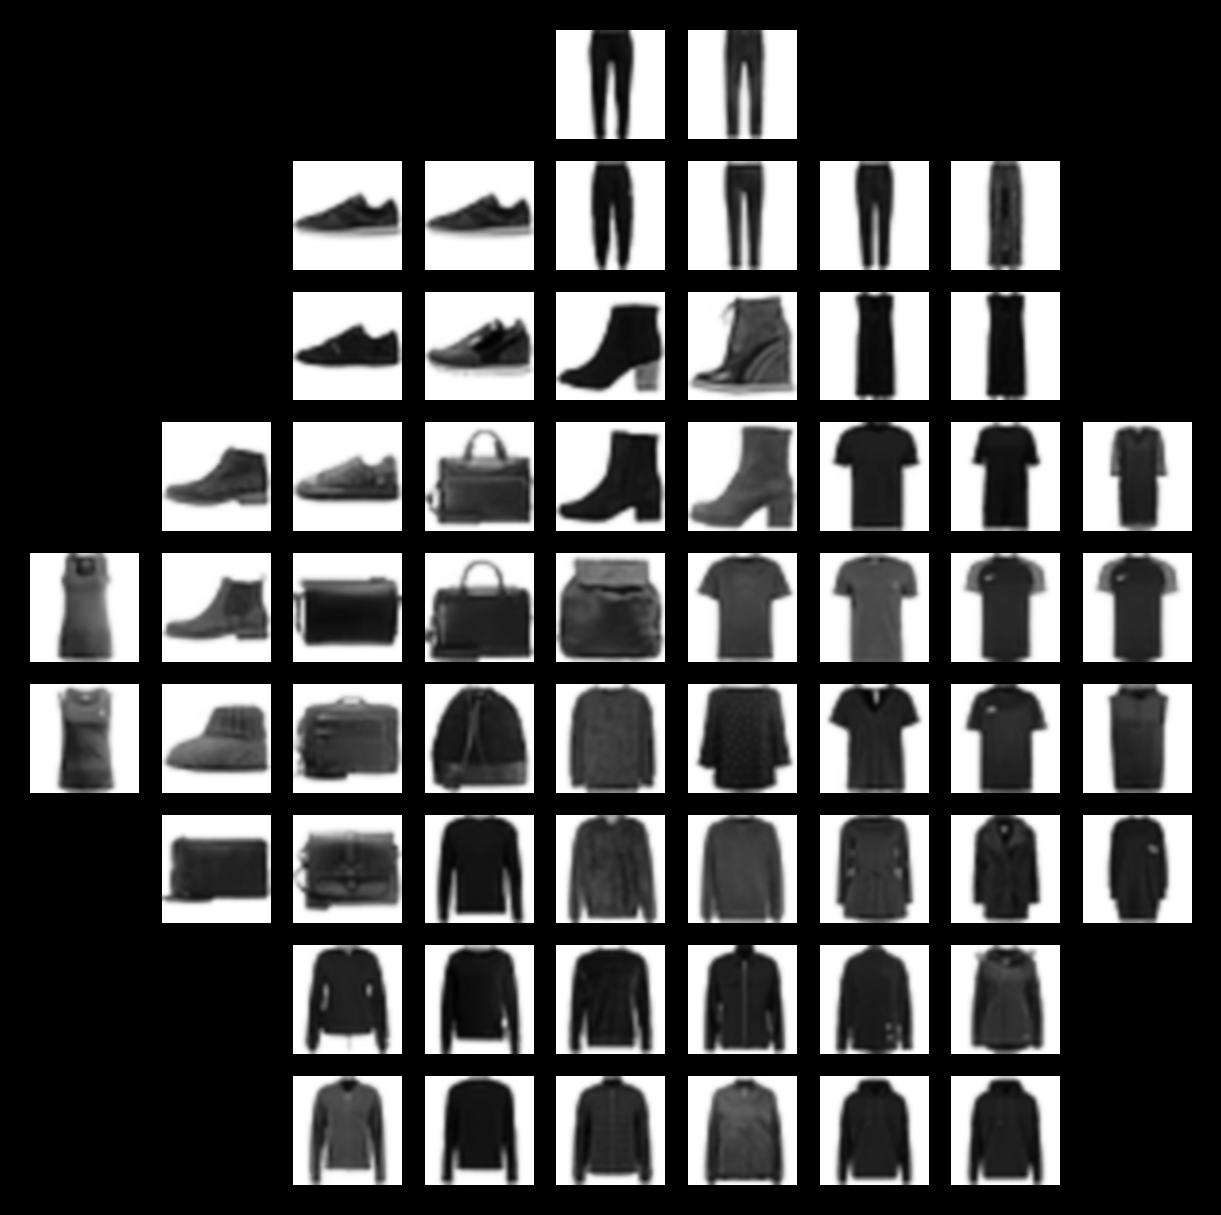

In [48]:
f = plt.figure(figsize=(5, 5), dpi=300)

som = pipe.named_steps["som"]

coordinates = np.array(som.neurons_)

min, max = (np.array(som.neurons_).min(), np.array(som.neurons_).max())
min_x = coordinates[:,0].min()
max_x = coordinates[:,0].max()
min_y = coordinates[:,1].min()
max_y = coordinates[:,1].max()

nn = pipe.transform(data).argmin(axis=0)

gs = GridSpec(abs(min_x) + max_x, abs(min_y) + max_y, figure=f)
for index, neuron in enumerate(coordinates):
    neuron += [min_x-1, min_y-1]
    plt.subplot(gs[neuron[0], neuron[1]])
    plt.imshow(
        data.to_numpy()[nn[index]].reshape(28, 28), cmap="Greys", interpolation="bicubic"
    )
    plt.axis("off")

plt.savefig(fname="fashion_mnist.png")

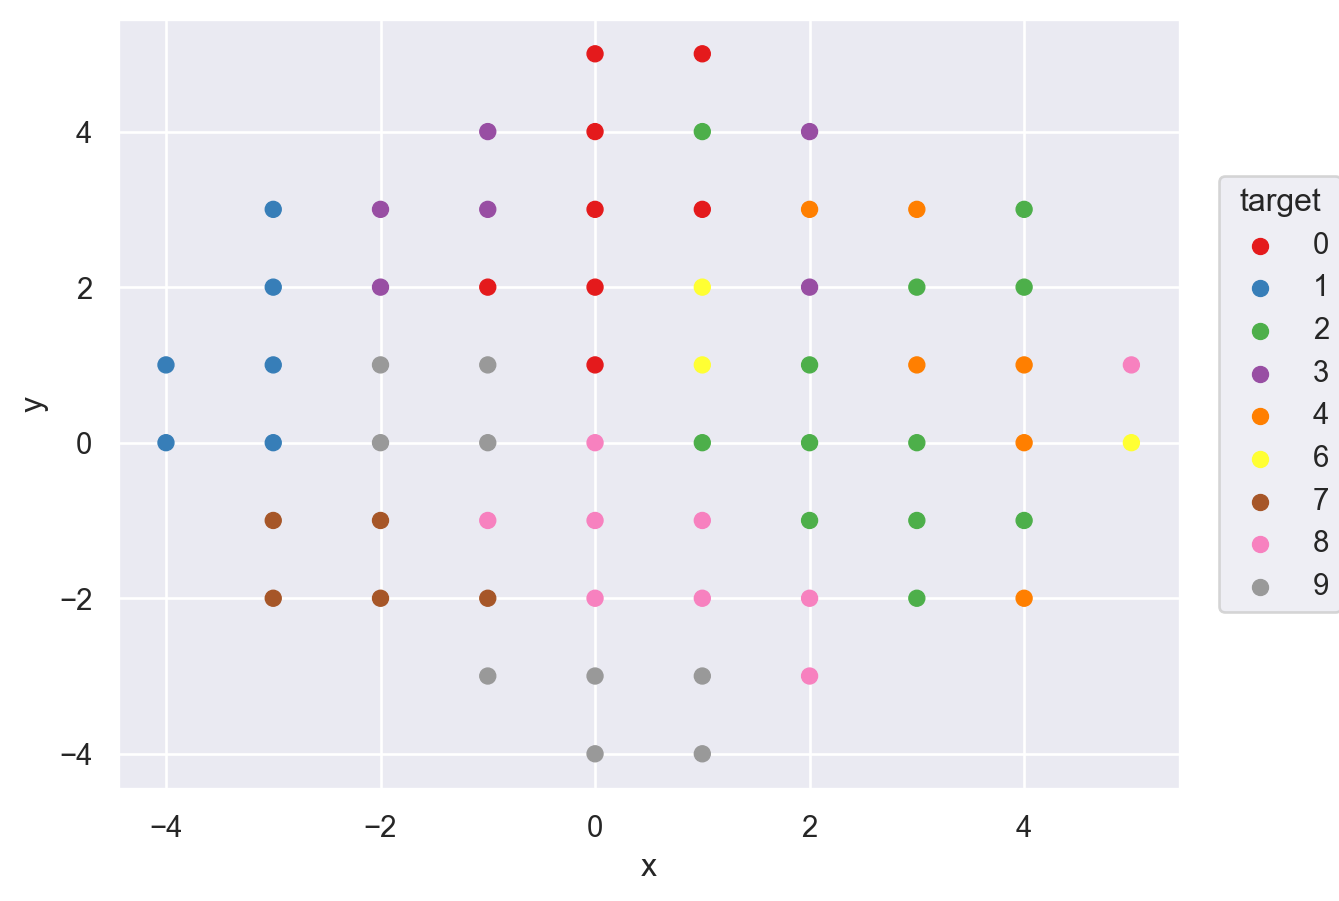

<Figure size 1500x1500 with 0 Axes>

In [57]:
weights = pipe.named_steps["som"].weights_

f = plt.figure(figsize=(5, 5), dpi=300)

dots = pd.DataFrame(np.array(pipe.named_steps["som"].neurons_), columns=["x", "y"])
dots["epoch_created"] = list(
    dict(pipe.named_steps["som"].som_.nodes.data("epoch_created")).values()
)
dots["error"] = list(dict(pipe.named_steps["som"].som_.nodes.data("error")).values())
dots["target"] = fashion_mnist_target[nn].to_numpy()
p = so.Plot(dots, x="x", y="y", color="target").add(so.Dot()).scale(color="Set1").plot()

p.save(loc="fashion_mnist_map.png", bbox_inches="tight")
